In [73]:
import pandas as pd
import numpy as np

from scipy.integrate import solve_ivp
from scipy.optimize import minimize

from datetime import timedelta, datetime

from tsfresh import extract_features

import matplotlib.pyplot as plt
%matplotlib inline

# Читаем данные

In [74]:
train = pd.read_csv("data/covid/train.csv")
test = pd.read_csv("data/covid/test.csv")

In [75]:
train.head()

Id Province_State Country_Region        Date  ConfirmedCases  Fatalities
0   1            NaN    Afghanistan  2020-01-22             0.0         0.0
1   2            NaN    Afghanistan  2020-01-23             0.0         0.0
2   3            NaN    Afghanistan  2020-01-24             0.0         0.0
3   4            NaN    Afghanistan  2020-01-25             0.0         0.0
4   5            NaN    Afghanistan  2020-01-26             0.0         0.0

In [76]:
test.head(60)

ForecastId Province_State Country_Region        Date
0            1            NaN    Afghanistan  2020-03-26
1            2            NaN    Afghanistan  2020-03-27
2            3            NaN    Afghanistan  2020-03-28
3            4            NaN    Afghanistan  2020-03-29
4            5            NaN    Afghanistan  2020-03-30
5            6            NaN    Afghanistan  2020-03-31
6            7            NaN    Afghanistan  2020-04-01
7            8            NaN    Afghanistan  2020-04-02
8            9            NaN    Afghanistan  2020-04-03
9           10            NaN    Afghanistan  2020-04-04
10          11            NaN    Afghanistan  2020-04-05
11          12            NaN    Afghanistan  2020-04-06
12          13            NaN    Afghanistan  2020-04-07
13          14            NaN    Afghanistan  2020-04-08
14          15            NaN    Afghanistan  2020-04-09
15          16            NaN    Afghanistan  2020-04-10
16          17            NaN    Afghanistan  2020-04-11
17          18            NaN    Afghanistan  2020-04-12
18          19            NaN    Afghanistan  2020-04-13
19          20            NaN    Afghanistan  2020-04-14
20          21            NaN    Afghanistan  2020-04-15
21          22            NaN    Afghanistan  2020-04-16
22          23            NaN    Afghanistan  2020-04-17
23          24            NaN    Afghanistan  2020-04-18
24          25            NaN    Afghanistan  2020-04-19
25          26            NaN    Afghanistan  2020-04-20
26          27            NaN    Afghanistan  2020-04-21
27          28            NaN    Afghanistan  2020-04-22
28          29            NaN    Afghanistan  2020-04-23
29          30            NaN    Afghanistan  2020-04-24
30          31            NaN    Afghanistan  2020-04-25
31          32            NaN    Afghanistan  2020-04-26
32          33            NaN    Afghanistan  2020-04-27
33          34            NaN    Afghanistan  2020-04-28
34          35            NaN    Afghanistan  2020-04-29
35          36            NaN    Afghanistan  2020-04-30
36          37            NaN    Afghanistan  2020-05-01
37          38            NaN    Afghanistan  2020-05-02
38          39            NaN    Afghanistan  2020-05-03
39          40            NaN    Afghanistan  2020-05-04
40          41            NaN    Afghanistan  2020-05-05
41          42            NaN    Afghanistan  2020-05-06
42          43            NaN    Afghanistan  2020-05-07
43          44            NaN        Albania  2020-03-26
44          45            NaN        Albania  2020-03-27
45          46            NaN        Albania  2020-03-28
46          47            NaN        Albania  2020-03-29
47          48            NaN        Albania  2020-03-30
48          49            NaN        Albania  2020-03-31
49          50            NaN        Albania  2020-04-01
50          51            NaN        Albania  2020-04-02
51          52            NaN        Albania  2020-04-03
52          53            NaN        Albania  2020-04-04
53          54            NaN        Albania  2020-04-05
54          55            NaN        Albania  2020-04-06
55          56            NaN        Albania  2020-04-07
56          57            NaN        Albania  2020-04-08
57          58            NaN        Albania  2020-04-09
58          59            NaN        Albania  2020-04-10
59          60            NaN        Albania  2020-04-11

In [77]:
train["ConfirmedCases"] = train["ConfirmedCases"].astype(np.int32)
train["Fatalities"] = train["Fatalities"].astype(np.int32)
train["Date"] = pd.to_datetime(train["Date"])
train.sort_values(by="Date")

undata = pd.read_csv("data/undata/country_profile_variables.csv")

In [78]:
display(train.head())
display(undata.head())

Id Province_State Country_Region       Date  ConfirmedCases  Fatalities
0   1            NaN    Afghanistan 2020-01-22               0           0
1   2            NaN    Afghanistan 2020-01-23               0           0
2   3            NaN    Afghanistan 2020-01-24               0           0
3   4            NaN    Afghanistan 2020-01-25               0           0
4   5            NaN    Afghanistan 2020-01-26               0           0

country          Region Surface area (km2)  \
0     Afghanistan    SouthernAsia             652864   
1         Albania  SouthernEurope              28748   
2         Algeria  NorthernAfrica            2381741   
3  American Samoa       Polynesia                199   
4         Andorra  SouthernEurope                468   

   Population in thousands (2017)  Population density (per km2, 2017)  \
0                           35530                                54.4   
1                            2930                               106.9   
2                           41318                                17.3   
3                              56                               278.2   
4                              77                               163.8   

   Sex ratio (m per 100 f, 2017)  \
0                          106.3   
1                          101.9   
2                          102.0   
3                          103.6   
4                          102.3   

   GDP: Gross domestic product (million current US$)  \
0                                              20270   
1                                              11541   
2                                             164779   
3                                                -99   
4                                               2812   

  GDP growth rate (annual %, const. 2005 prices)  \
0                                           -2.4   
1                                            2.6   
2                                            3.8   
3                                            -99   
4                                            0.8   

   GDP per capita (current US$) Economy: Agriculture (% of GVA)  ...  \
0                         623.2                            23.3  ...   
1                        3984.2                            22.4  ...   
2                        4154.1                            12.2  ...   
3                         -99.0                             -99  ...   
4                       39896.4                             0.5  ...   

   Mobile-cellular subscriptions (per 100 inhabitants).1  \
0                                                8.3       
1                                               63.3       
2                                               38.2       
3                                                -99       
4                                               96.9       

   Individuals using the Internet (per 100 inhabitants)  \
0                                                 42      
1                                                130      
2                                                135      
3                                                 92      
4                                                 13      

  Threatened species (number) Forested area (% of land area)  \
0                         2.1                        9.8/0.3   
1                        28.2                        5.7/2.0   
2                         0.8                      145.4/3.7   
3                        87.9                            -99   
4                        34.0                        0.5/6.4   

  CO2 emission estimates (million tons/tons per capita)  \
0                                                 63      
1                                                 84      
2                                               5900      
3                                                -99      
4                                                  1      

  Energy production, primary (Petajoules)  \
0                                       5   
1                                      36   
2                                      55   
3                                     -99   
4                                     119   

  Energy supply per capita (Gigajoules)  \
0                             78.2/47.0   
1                             94.9/95.2   
2                             84.3/81.8   
3                           100.0/1

In [79]:
country_name = "Italy"
country_train = train[train["Country_Region"] == "Italy"].drop(["Province_State"], axis=1)

In [80]:
country_groupby = country_train.groupby(["Country_Region", "Date"]).agg({"ConfirmedCases": "sum", "Fatalities": "sum"})
country_conf = pd.pivot_table(country_groupby, values="ConfirmedCases", columns="Date")
country_fatal = pd.pivot_table(country_groupby, values="Fatalities", columns="Date")

country_population = int(undata[undata["country"] == country_name]["Population in thousands (2017)"]*1000)
country_susc = [country_population - country_conf.iloc[0, i] - country_fatal.iloc[0, i] for i in range(len(country_conf.columns))]

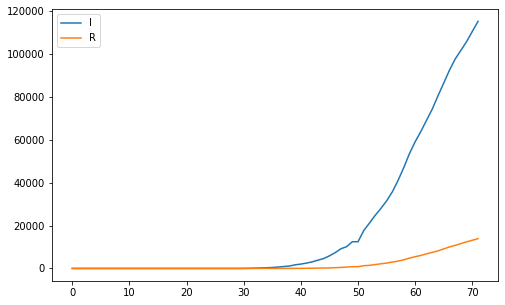

In [81]:
plt.figure(figsize=(8,5))
plt.plot(list(range(len(country_conf.columns))), country_conf.iloc[0, :], label="I")
plt.plot(list(range(len(country_fatal.columns))), country_fatal.iloc[0, :], label="R")
plt.legend()

# Строим SIR модель на одной стране

1. $S(t)$ - восприимчивыые
3. $I(t)$ - инфицированные
4. $R(t)$ - невосприимчивые

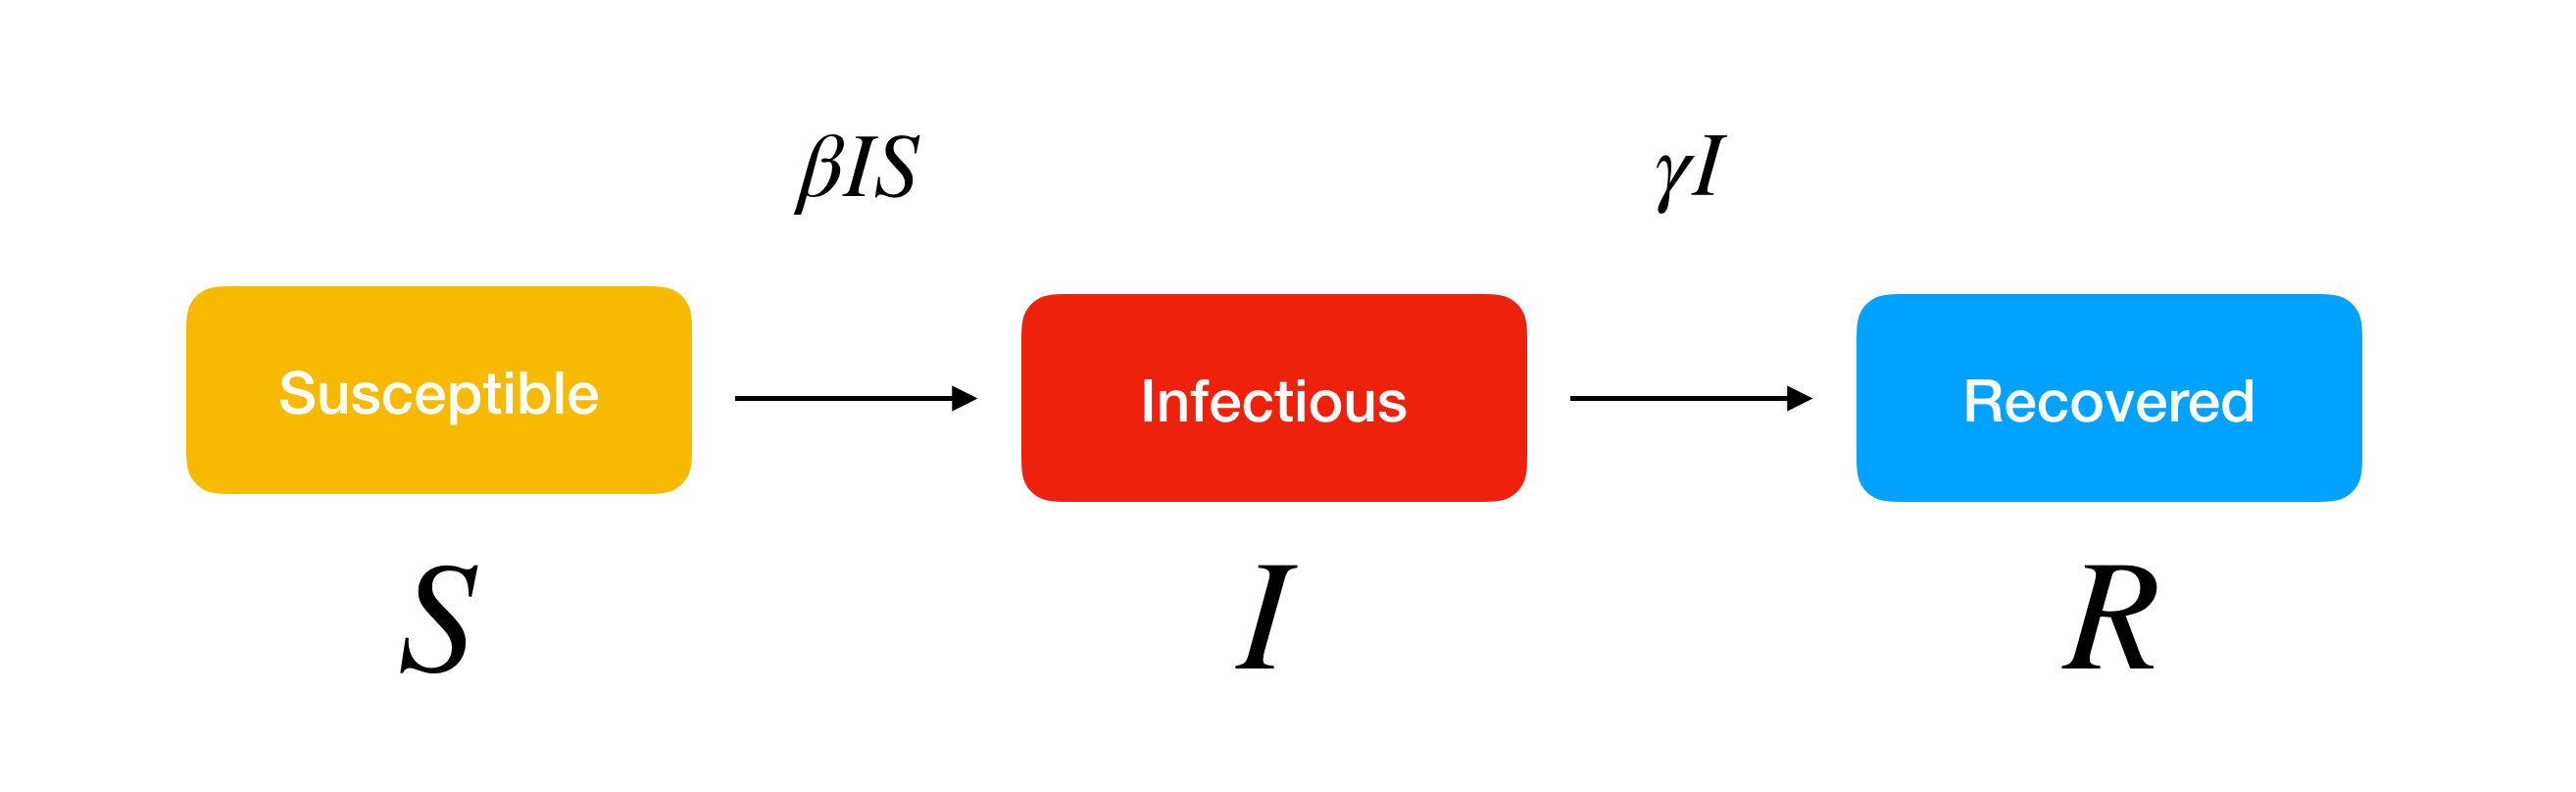

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/29728a7d4bebe8197dca7d873d81b9dce954522e" />

В модели мы не будем учитывать смертность и рождаемость, потому что период болезни меньше жизни человека

* $D = 1/\gamma$, где $D$ - среднее количество дней, необходимое для выздоровления
* $R_0 = \beta/\gamma$ (basic reproduction number) - среднее количество людей, зараженных от одного человека

In [82]:
country_conf

Date            2020-01-22  2020-01-23  2020-01-24  2020-01-25  2020-01-26  \
ConfirmedCases           0           0           0           0           0   

Date            2020-01-27  2020-01-28  2020-01-29  2020-01-30  2020-01-31  \
ConfirmedCases           0           0           0           0           2   

Date            ...  2020-03-24  2020-03-25  2020-03-26  2020-03-27  \
ConfirmedCases  ...       69176       74386       80589       86498   

Date            2020-03-28  2020-03-29  2020-03-30  2020-03-31  2020-04-01  \
ConfirmedCases       92472       97689      101739      105792      110574   

Date            2020-04-02  
ConfirmedCases      115242  

[1 rows x 72 columns]

In [86]:
S_0, I_0, R_0 = 0, 0, 0

def loss(params, data):
    """ Using RMSE """
    beta, gamma = params
    size = len(data)
    
    def SIR(t, y):
        return [-beta*y[0]*y[1], beta*y[0]*y[1] - gamma*y[1], gamma*y[1]]
    
    prediction = solve_ivp(
        SIR,
        (0, size),
        [S_0, I_0, R_0],
        t_eval=np.arange(0, size, 1),
        vectorized=True
    )
    
    return np.sqrt(np.mean((prediction.y[1] - data)**2))

# Nfeval = 1
# def callbackF(Xi, data):
#     global Nfeval
#     print("{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6f}".format(Nfeval, Xi[0], Xi[1]))
#     Nfeval += 1
    
class SIRLearner:
    optimal_params = [0.0, 0.0]
    
    def __init__(self, data):
        global I_0
        global R_0
        global S_0
        groupby = data.groupby(["Country_Region", "Date"]).agg({"ConfirmedCases": "sum", "Fatalities": "sum"})
        self.confirmed = pd.pivot_table(groupby, values="ConfirmedCases", columns="Date").values[0]
        self.fatality = pd.pivot_table(groupby, values="Fatalities", columns="Date").values[0]
        
        first_conf = 0
        for i in range(len(self.confirmed)):
            if self.confirmed[i] > 0:
                first_conf = i
                break
                
        self.confirmed = self.confirmed[first_conf:]
        self.fatality = self.fatality[first_conf:]
                
        I_0 = self.confirmed[0]
        R_0 = self.fatality[0]
        S_0 = int(undata[undata["country"] == country_name]["Population in thousands (2017)"]*1000)
#         self.susceptible = [population - self.confirmed[i] - self.fatality[i] for i in range(len(country_conf.columns))]        
#         self.data = np.concatenate(([self.susceptible], [self.confirmed], [self.fatality]), axis=0)
        
    
    def predict(self, predict_range=10):        
        size = len(self.confirmed) + predict_range
        
        beta, gamma = self.optimal_params
        def SIR(t, y):
            return [-beta*y[0]*y[1], beta*y[0]*y[1] - gamma*y[1], gamma*y[1]]
        
        return solve_ivp(SIR, [0, size], [S_0, I_0, R_0], t_eval=np.arange(0, size, 1))
    
    
    def train(self):
        data =  self.confirmed
        optimal = minimize(
            loss,
            [0.001, 0.001],                               # init values
            args=(data),                                  # extra arguments passed to the obj
            method="L-BFGS-B", 
            bounds=[(0.00000001, 0.4), (0.00000001, 0.4)],# bounds on variables for L-BFGS-Bб
#             callback=callbackF, 
        )
        print(optimal)
        # beta, gamma = optimal.x
        self.optimal_params = optimal.x

In [87]:
sir_learner = SIRLearner(train[train["Country_Region"] == "Italy"])
print(I_0, R_0)

2 0


In [ ]:
sir_learner.train()

# Learning CatBoost models

In [9]:
train

Id Province_State Country_Region       Date  ConfirmedCases  \
0          1            NaN    Afghanistan 2020-01-22               0   
1          2            NaN    Afghanistan 2020-01-23               0   
2          3            NaN    Afghanistan 2020-01-24               0   
3          4            NaN    Afghanistan 2020-01-25               0   
4          5            NaN    Afghanistan 2020-01-26               0   
...      ...            ...            ...        ...             ...   
22027  32703            NaN       Zimbabwe 2020-03-29               7   
22028  32704            NaN       Zimbabwe 2020-03-30               7   
22029  32705            NaN       Zimbabwe 2020-03-31               8   
22030  32706            NaN       Zimbabwe 2020-04-01               8   
22031  32707            NaN       Zimbabwe 2020-04-02               9   

       Fatalities  
0               0  
1               0  
2               0  
3               0  
4               0  
...           ...  
22027           1  
22028           1  
22029           1  
22030           1  
22031           1  

[22032 rows x 6 columns]

In [33]:
train.loc[train["Province_State"].isna() == False, "Country_Region"] += "_" + train.loc[train["Province_State"].isna() == False, "Province_State"]
train = train.drop(["Province_State"], axis=1)

In [51]:
train.head()

Id Country_Region        Date  ConfirmedCases  \
_temporary_index_column                                                  
0                         1    Afghanistan  2020-01-22             0.0   
1                         2    Afghanistan  2020-01-23             0.0   
2                         3    Afghanistan  2020-01-24             0.0   
3                         4    Afghanistan  2020-01-25             0.0   
4                         5    Afghanistan  2020-01-26             0.0   

                         Fatalities  
_temporary_index_column              
0                               0.0  
1                               0.0  
2                               0.0  
3                               0.0  
4                               0.0

In [49]:
extracted_features = extract_features(train.drop(["Id"], axis=1), column_id="Country_Region", column_sort="Date")

ValueError: There is no column with values in your data!

In [ ]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())
    data.columns = ["y"]

    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data)*(1-test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)

    data.index = data.index.to_datetime()
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1

    # считаем средние только по тренировочной части, чтобы избежать лика
    data['weekday_average'] = map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday)
    data["hour_average"] = map(code_mean(data[:test_index], 'hour', "y").get, data.hour)

    # выкидываем закодированные средними признаки 
    data.drop(["hour", "weekday"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]

    return X_train, X_test, y_train, y_test

In [ ]:
import xgboost as xgb

def XGB_forecast(data, lag_start=5, lag_end=20, test_size=0.15, scale=1.96):

    # исходные данные
    X_train, X_test, y_train, y_test = prepareData(dataset.Users, lag_start, lag_end, test_size)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)

    # задаём параметры
    params = {
        'objective': 'reg:linear',
        'booster':'gblinear'
    }
    trees = 1000

    # прогоняем на кросс-валидации с метрикой rmse
    cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=trees)

    # обучаем xgboost с оптимальным числом деревьев, подобранным на кросс-валидации
    bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())

    # можно построить кривые валидации
    #cv.plot(y=['test-mae-mean', 'train-mae-mean'])

    # запоминаем ошибку на кросс-валидации
    deviation = cv.loc[cv['test-rmse-mean'].argmin()]["test-rmse-mean"]

    # посмотрим, как модель вела себя на тренировочном отрезке ряда
    prediction_train = bst.predict(dtrain)
    plt.figure(figsize=(15, 5))
    plt.plot(prediction_train)
    plt.plot(y_train)
    plt.axis('tight')
    plt.grid(True)

    # и на тестовом
    prediction_test = bst.predict(dtest)
    lower = prediction_test-scale*deviation
    upper = prediction_test+scale*deviation

    Anomalies = np.array([np.NaN]*len(y_test))
    Anomalies[y_test<lower] = y_test[y_test<lower]

    plt.figure(figsize=(15, 5))
    plt.plot(prediction_test, label="prediction")
    plt.plot(lower, "r--", label="upper bond / lower bond")
    plt.plot(upper, "r--")
    plt.plot(list(y_test), label="y_test")
    plt.plot(Anomalies, "ro", markersize=10)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("XGBoost Mean absolute error {} users".format(round(mean_absolute_error(prediction_test, y_test))))
    plt.grid(True)
    plt.legend()